# Import libraries

In [1]:
import numpy as np
import pandas as pd

# Load data

In [3]:
encoded_applications = pd.read_csv("../Dataset/processed_applications.csv")
credits = pd.read_csv("../Dataset/scores.csv")

# Adjust Data
We split the data to train.

In [18]:
updated_applicants = pd.merge(encoded_applications, credits, on='id', how='left')
updated_applicants = updated_applicants.drop(['id'], axis=1)

In [19]:
applicants_w_records = updated_applicants.dropna(subset = ["total_score"])
applicants_no_records = updated_applicants.loc[updated_applicants["total_score"].isna()]


We split away around 20% of the applicants with records as test data.

In [20]:
removal_index_labeled = range(0, len(applicants_w_records), 5)
test_data = applicants_w_records.reset_index().filter(removal_index_labeled, axis=0)
train_data = applicants_w_records.reset_index().drop(removal_index_labeled, axis=0)

In [21]:
x_test_data = test_data.drop(['credit_history_score', 'duration_score', 'total_score'], axis=1).to_numpy(dtype=float)
y_test_data = test_data['total_score'].to_numpy(dtype=float)
x_train_data = train_data.drop(['credit_history_score', 'duration_score', 'total_score'], axis=1).to_numpy(dtype=float)
y_train_data = train_data['total_score'].to_numpy(dtype=float)

We split the unlabelled data into 3 sets.

In [22]:
removal_index_unlabelled1 = range(0, len(applicants_no_records), 3)
removal_index_unlabelled2 = range(1, len(applicants_no_records), 3)
removal_index_unlabelled3 = range(2, len(applicants_no_records), 3)
unlabelled_data_1 = applicants_no_records.reset_index().filter(removal_index_unlabelled1, axis=0)
unlabelled_data_2 = applicants_no_records.reset_index().filter(removal_index_unlabelled2, axis=0)
unlabelled_data_3 = applicants_no_records.reset_index().filter(removal_index_unlabelled3, axis=0)

x_unlabelled_data_1 = unlabelled_data_1.drop(['credit_history_score', 'duration_score', 'total_score'], axis=1).to_numpy(dtype=float)
x_unlabelled_data_2 = unlabelled_data_2.drop(['credit_history_score', 'duration_score', 'total_score'], axis=1).to_numpy(dtype=float)
x_unlabelled_data_3 = unlabelled_data_3.drop(['credit_history_score', 'duration_score', 'total_score'], axis=1).to_numpy(dtype=float)

We remove first column as they are indexes.

In [23]:
x_test_data = np.delete(x_test_data, 0, axis=1)
x_train_data = np.delete(x_train_data, 0, axis=1)
x_unlabelled_data_1 = np.delete(x_unlabelled_data_1, 0, axis=1)
x_unlabelled_data_2 = np.delete(x_unlabelled_data_2, 0, axis=1)
x_unlabelled_data_3 = np.delete(x_unlabelled_data_3, 0, axis=1)

# Semi-supervised Learning
We will now use the learning model and implement Neural Network.

Datasets:
* x_test_data
* y_test_data
* x_train_data
* y_train_data
* x_unlabelled_data_1
* x_unlabelled_data_2
* x_unlabelled_data_3

## Neural Network
We first create our NN model.

In [24]:
import keras

from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout
from keras import optimizers

In [25]:
model_one = Sequential([
    Dense(units=256, input_dim=x_train_data.shape[1], activation='relu'),
    Dense(units=256, activation='relu'),
    Dense(units=1, activation='sigmoid')
])

model_one.summary()

model_one.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               8960      
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 75,009
Trainable params: 75,009
Non-trainable params: 0
_________________________________________________________________


We train our first set of labelled data

In [26]:
first_training = model_one.fit(x_train_data, y_train_data, batch_size=8, epochs=30, validation_data=(x_test_data, y_test_data))

Epoch 1/30
3646/3646 [==============================] - 11s 3ms/step - loss: 0.0106 - val_loss: 0.0104
Epoch 2/30
3646/3646 [==============================] - 10s 3ms/step - loss: 0.0104 - val_loss: 0.0106
Epoch 3/30
3646/3646 [==============================] - 10s 3ms/step - loss: 0.0104 - val_loss: 0.0104
Epoch 4/30
3646/3646 [==============================] - 11s 3ms/step - loss: 0.0103 - val_loss: 0.0103
Epoch 5/30
3646/3646 [==============================] - 10s 3ms/step - loss: 0.0102 - val_loss: 0.0103
Epoch 6/30
3646/3646 [==============================] - 10s 3ms/step - loss: 0.0101 - val_loss: 0.0102
Epoch 7/30
3646/3646 [==============================] - 10s 3ms/step - loss: 0.0100 - val_loss: 0.0102
Epoch 8/30
3646/3646 [==============================] - 11s 3ms/step - loss: 0.0099 - val_loss: 0.0103
Epoch 9/30
3646/3646 [==============================] - 10s 3ms/step - loss: 0.0098 - val_loss: 0.0100
Epoch 10/30
3646/3646 [==============================] - 10s 3ms/step - l

We create our first pesudo-labels.

The pseudo-labels and its applicant data are then added to the training data.

In [27]:
pseudo_label_1 = model_one.predict(x_unlabelled_data_1)

new_x_train_data = np.vstack((x_train_data, x_unlabelled_data_1))
new_y_train_data = np.append(y_train_data, pseudo_label_1)

4189/4189 [==============================] - 6s 2ms/step


### Second training

In [28]:
model_two = Sequential([
    Dense(units=256, input_dim=x_train_data.shape[1], activation='relu'),
    Dropout(0.2),
    Dense(units=256, activation='relu'),
    Dropout(0.2),
    Dense(units=1, activation='sigmoid')
])

model_two.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

second_training = model_two.fit(new_x_train_data, new_y_train_data, batch_size=64, epochs=30, validation_data=(x_test_data, y_test_data))

Epoch 1/30
2550/2550 [==============================] - 11s 4ms/step - loss: 0.0029 - val_loss: 0.0104
Epoch 2/30
2550/2550 [==============================] - 9s 3ms/step - loss: 0.0025 - val_loss: 0.0103
Epoch 3/30
2550/2550 [==============================] - 10s 4ms/step - loss: 0.0023 - val_loss: 0.0102
Epoch 4/30
2550/2550 [==============================] - 9s 4ms/step - loss: 0.0022 - val_loss: 0.0103
Epoch 5/30
2550/2550 [==============================] - 10s 4ms/step - loss: 0.0022 - val_loss: 0.0102
Epoch 6/30
2550/2550 [==============================] - 10s 4ms/step - loss: 0.0021 - val_loss: 0.0101
Epoch 7/30
2550/2550 [==============================] - 10s 4ms/step - loss: 0.0021 - val_loss: 0.0100
Epoch 8/30
2550/2550 [==============================] - 10s 4ms/step - loss: 0.0021 - val_loss: 0.0100
Epoch 9/30
2550/2550 [==============================] - 10s 4ms/step - loss: 0.0021 - val_loss: 0.0100
Epoch 10/30
2550/2550 [==============================] - 10s 4ms/step - los

Second pseudo-labelling and adjustment to training data.

In [29]:
pseudo_label_2 = model_one.predict(x_unlabelled_data_2)

new_x_train_data = np.vstack((new_x_train_data, x_unlabelled_data_2))
new_y_train_data = np.append(new_y_train_data, pseudo_label_2)

4189/4189 [==============================] - 7s 2ms/step


### Third training

In [30]:
model_three = Sequential([
    Dense(units=256, input_dim=x_train_data.shape[1], activation='relu'),
    Dropout(0.2),
    Dense(units=128, activation='relu'),
    Dropout(0.2),
    Dense(units=1, activation='sigmoid')
])

model_three.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

third_training = model_three.fit(new_x_train_data, new_y_train_data, batch_size=128, epochs=30, validation_data=(x_test_data, y_test_data))

Epoch 1/30
2323/2323 [==============================] - 8s 3ms/step - loss: 0.0020 - val_loss: 0.0103
Epoch 2/30
2323/2323 [==============================] - 10s 4ms/step - loss: 0.0016 - val_loss: 0.0103
Epoch 3/30
2323/2323 [==============================] - 11s 5ms/step - loss: 0.0015 - val_loss: 0.0102
Epoch 4/30
2323/2323 [==============================] - 10s 4ms/step - loss: 0.0014 - val_loss: 0.0101
Epoch 5/30
2323/2323 [==============================] - 11s 5ms/step - loss: 0.0014 - val_loss: 0.0101
Epoch 6/30
2323/2323 [==============================] - 11s 5ms/step - loss: 0.0013 - val_loss: 0.0101
Epoch 7/30
2323/2323 [==============================] - 9s 4ms/step - loss: 0.0013 - val_loss: 0.0100
Epoch 8/30
2323/2323 [==============================] - 10s 4ms/step - loss: 0.0013 - val_loss: 0.0100
Epoch 9/30
2323/2323 [==============================] - 11s 5ms/step - loss: 0.0013 - val_loss: 0.0100
Epoch 10/30
2323/2323 [==============================] - 10s 4ms/step - los

Third pseudo-labelling and adjustment to training data.

In [31]:
pseudo_label_3 = model_one.predict(x_unlabelled_data_3)

new_x_train_data = np.vstack((new_x_train_data, x_unlabelled_data_3))
new_y_train_data = np.append(new_y_train_data, pseudo_label_3)

4189/4189 [==============================] - 7s 2ms/step


### Fourth training

In [32]:
model_four = Sequential([
    Dense(units=256, input_dim=x_train_data.shape[1], activation='relu'),
    Dropout(0.2),
    Dense(units=128, activation='relu'),
    Dropout(0.2),
    Dense(units=1, activation='sigmoid')
])

model_four.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

fourth_training = model_four.fit(new_x_train_data, new_y_train_data, batch_size=128, epochs=30, validation_data=(x_test_data, y_test_data))

Epoch 1/30
3370/3370 [==============================] - 6s 2ms/step - loss: 0.0016 - val_loss: 0.0103
Epoch 2/30
3370/3370 [==============================] - 13s 4ms/step - loss: 0.0012 - val_loss: 0.0102
Epoch 3/30
3370/3370 [==============================] - 14s 4ms/step - loss: 0.0011 - val_loss: 0.0102
Epoch 4/30
3370/3370 [==============================] - 14s 4ms/step - loss: 0.0011 - val_loss: 0.0101
Epoch 5/30
3370/3370 [==============================] - 13s 4ms/step - loss: 0.0010 - val_loss: 0.0101
Epoch 6/30
3370/3370 [==============================] - 14s 4ms/step - loss: 0.0010 - val_loss: 0.0101
Epoch 7/30
3370/3370 [==============================] - 14s 4ms/step - loss: 9.8676e-04 - val_loss: 0.0101
Epoch 8/30
3370/3370 [==============================] - 14s 4ms/step - loss: 9.7327e-04 - val_loss: 0.0101
Epoch 9/30
3370/3370 [==============================] - 14s 4ms/step - loss: 9.6170e-04 - val_loss: 0.0100
Epoch 10/30
3370/3370 [==============================] - 14s 4

### Testing accuracy
We will now test the sum squared error of our model.

In [33]:
from sklearn.metrics import mean_squared_error

test_accuracy = model_four.predict(x_test_data)
mean_squared_error(y_test_data, test_accuracy)

228/228 [==============================] - 0s 2ms/step


0.00988013955881512

# Progress of mean sum squared

First training

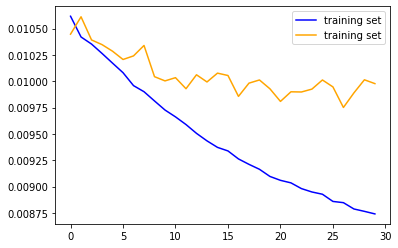

In [34]:
import matplotlib.pyplot as plt

plt.plot(range(30), first_training.history["loss"], label="training set", color = "blue")
plt.plot(range(30), first_training.history["val_loss"], label="training set", color = "orange")
plt.legend()
plt.show()

Second training

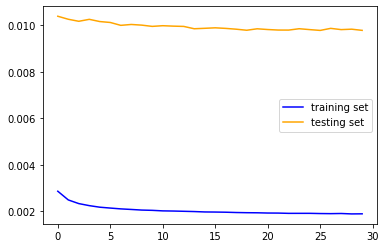

In [35]:
plt.plot(range(30), second_training.history["loss"], label="training set", color = "blue")
plt.plot(range(30), second_training.history["val_loss"], label="testing set", color = "orange")
plt.legend()
plt.show()

Third training

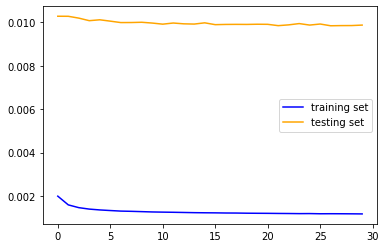

In [36]:
plt.plot(range(30), third_training.history["loss"], label="training set", color = "blue")
plt.plot(range(30), third_training.history["val_loss"], label="testing set", color = "orange")
plt.legend()
plt.show()

Fourth training

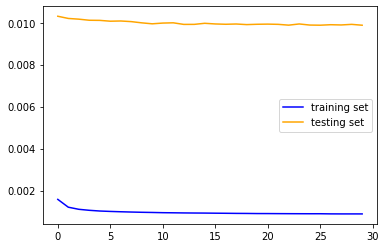

In [37]:
plt.plot(range(30), fourth_training.history["loss"], label="training set", color = "blue")
plt.plot(range(30), fourth_training.history["val_loss"], label="testing set", color = "orange")
plt.legend()
plt.show()

Running model on actual labelled data shows a significantly better performance than adding layers of pseudo-labelled data. We try to run the model on the actual labelled data with more sophisticated layers.

In [60]:
pure_model = Sequential([
    Dense(units=300, input_dim=x_train_data.shape[1], activation='relu'),
    Dropout(0.2),
    Dense(units=300, activation='relu'),
    Dropout(0.2),
    Dense(units=1, activation='sigmoid')
])

pure_model.summary()

pure_model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

pure_training = pure_model.fit(x_train_data, y_train_data, batch_size=16, epochs=120, validation_data=(x_test_data, y_test_data))

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 300)               10500     
                                                                 
 dropout_17 (Dropout)        (None, 300)               0         
                                                                 
 dense_29 (Dense)            (None, 300)               90300     
                                                                 
 dropout_18 (Dropout)        (None, 300)               0         
                                                                 
 dense_30 (Dense)            (None, 1)                 301       
                                                                 
Total params: 101,101
Trainable params: 101,101
Non-trainable params: 0
_________________________________________________________________
Epoch 1/120
1823/1823 [=========================

# Plotting of performance

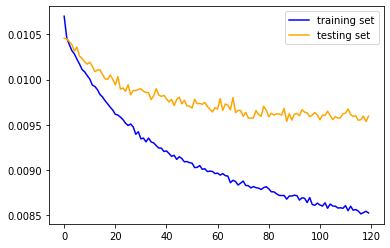

In [61]:
plt.plot(range(120), pure_training.history["loss"], label="training set", color = "blue")
plt.plot(range(120), pure_training.history["val_loss"], label="testing set", color = "orange")
plt.legend()
plt.show()

# MSE of pure model

In [62]:
pure_model_prediction = pure_model.predict(x_test_data)
mean_squared_error(y_test_data, pure_model_prediction)

228/228 [==============================] - 0s 803us/step


0.009593649522427618

# Comparison between SSL and Single NN Model

(0.0094, 0.0107)

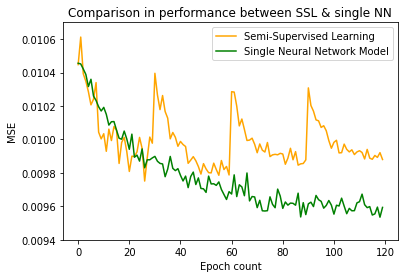

In [69]:
all_nn_hist = first_training.history["val_loss"] + second_training.history["val_loss"] + third_training.history["val_loss"] + fourth_training.history["val_loss"]

plt.plot(range(120), all_nn_hist, label="Semi-Supervised Learning", color = "orange")
plt.plot(range(120), pure_training.history["val_loss"], label="Single Neural Network Model", color = "green")
plt.title("Comparison in performance between SSL & single NN")
plt.xlabel("Epoch count")
plt.ylabel("MSE")
plt.legend()
plt.ylim(0.0094, 0.0107)